In [1]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "llama2", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT

'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}'

### Original Dataset

In [2]:
import pandas as pd
df = pd.read_csv("en-sp.csv")
df = df.sample(250, random_state=42)
# df to dict without indices
df_dict = df.to_dict(orient='records')
# dict with two keys: english and spanish
original_data = {"english": [], "spanish": []}
for row in df_dict:
    original_data["english"].append(row["english"])
    original_data["spanish"].append(row["spanish"])
original_data = Dataset.from_dict(original_data)
original_data["english"][:5], original_data["spanish"][:5]

(['How boring!',
  'I love sports.',
  'Would you like to swap jobs?',
  'My mother did nothing but weep.',
  'Croatia is in the southeastern part of Europe.'],
 ['¡Qué aburrimiento!',
  'Adoro el deporte.',
  '¿Te gustaría que intercambiemos los trabajos?',
  'Mi madre no hizo nada sino llorar.',
  'Croacia está en el sudeste de Europa.'])

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "english": \"\"\"{question}\"\"\",
    "spanish": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step. Respond with only the JSON object!
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["english"][0],
            answer=original_data["spanish"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )

    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_translations_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'question': "Don't be mad at me", 'answer': 'No te enfades conmigo'},
 {'question': 'I hate the weather here!', 'answer': '¡Odio el clima aquí!'},
 {'question': 'I saw a dog today.', 'answer': 'Vi un perro hoy.'},
 {'question': '"¿Qué es esto?"', 'answer': '"¿Qué es esto?"'},
 {'question': 'Open your eyes. ', 'answer': 'Abre los ojos. '},
 {'question': 'Come on!', 'answer': '¡Vamos!'},
 {'question': 'Let me do it.', 'answer': 'Déjame hacerlo.'},
 {'question': 'This is fine.', 'answer': 'Está bien.'},
 {'question': 'Your chances are zero', 'answer': 'Tus posibilidades son cero'},
 {'question': 'Stinking up the place!', 'answer': '¡ Apesta a todo dar!'},
 {'question': 'Thank you', 'answer': 'Gracias'},
 {'question': 'How high?', 'answer': '¿Qué tan alto?'},
 {'question': '¡Qué divertido!', 'answer': 'How exciting!'},
 {'question': 'Are you going to buy that?', 'answer': '¿Vas a comprar eso?'},
 {'question': 'Vamos a por ello!', 'answer': "Let's go!"},
 {'question': 'Is this food okay?'

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "english": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "spanish": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "english": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "spanish": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["english"]), len(training_sample["spanish"]), len(testing_sample["english"]), len(testing_sample["spanish"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [5]:
def has_correct_keywords(s):
    extract_keys = lambda x: re.findall(r'{(.*?)}', x)
    return extract_keys(s) == ['LANGUAGE', 'TEXT']


def opt_llm(instruction_score_pairs):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = opro.generate(
            prompt.format(pairs_str=pairs_str),
            model="gemini",  # gemini
            is_indeterministic=True,
        )
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    bleu_score = lambda expected, actual: sentence_bleu(
        [expected.split()], actual.split(), 
        weights=[1],
    )
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(LANGUAGE="Spanish", TEXT=sample_qa["english"]),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += bleu_score(sample_qa["spanish"], res)
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_translations_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        CHOSEN_PROMPT,
        f"{CHOSEN_PROMPT}. Think step by step.",
        f"{CHOSEN_PROMPT}. Take a deep breath and think step-by-step.",
        f"{CHOSEN_PROMPT}. Be concise and clear.",
        f"{CHOSEN_PROMPT}. You are the creator of an atlas.",
        f"{CHOSEN_PROMPT}. Explain your answer in simple terms.",
        # Prompt1 from Suggest Prompt
        """### Prompt
        
I'm going to tip $10 for a better solution!
```
### Instructions

### Example
Translate \"Hello, world!\" to French.
```

Your task is to help me to translate the following text to {LANGUAGE}. Please return only translated content, do not include the original text. 

{TEXT}

You MUST format the translated text in the following way: 

```
{{TRANSLATED TEXT}}
```

You will be penalized if you do not follow this format.

Answer a question given in a natural, human-like manner

---

Would you like me to add anything else? (yes/no)""",
        # Prompt2 from Suggest Prompt
        """Translate the following text to *{LANGUAGE}*.
Return only the translated content. Do not include the original text.

**Text**: {TEXT}

### Notes ###
- No need for polite language.
- Ensure your response is in *{LANGUAGE}*. 
- I'm offering a tip for a higher quality translation.""",
        # Prompt3 from Suggest Prompt
        """###Instruction###

Please help me to translate the following text to {LANGUAGE}. Please return only translated text, not including the origin text.

###Example###

####
{TEXT}
####

###Question###

What is the translated text?""",
        # Prompt4 from Suggest Prompt
        """####
Your task is to translate the following text to {LANGUAGE}. You MUST only return the translated content and exclude the original text.

{TEXT}

### Instruction###
I'm going to tip $100 for a better solution! I need the translation to be of high quality and accurate.""",
        # Prompt5 from Suggest Prompt
        """###Instruction###
Translate the following text into {LANGUAGE}:

###Example###
**English to Spanish:**
```
Original text: Hello, world!
Translated text: ¡Hola, mundo!
```

###Question###
I'm providing you with the original text below: {TEXT}. Translate it to {LANGUAGE} and return only the translated content without including the original text.""",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 20
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

### Prompt
        
I'm going to tip $10 for a better solution!
```
### Instructions

### Example
Translate "H…

Translate the following text to *{LANGUAGE}*.
Return only the translated content. Do not include the original …

###Instruction###

Please help me to translate the following text to {LANGUAGE}. Please return only translated…

####
Your task is to translate the following text to {LANGUAGE}. You MUST only return the translated content a…

###Instruction###
Translate the following text into {LANGUAGE}:

###Example###
**English to Spanish:**
```
Ori…

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text to {LANGUAGE}:\n\n```\n{TEXT}\n```', '### Instruction\n\nPlease help me to translate the following text to {LANGUAGE}. Please return only translated content, not including the original text. \n\nThe translation needs to be of high quality and flawless. You should assume that grammar, sentence structure and word choice are all accurate. The text you provide should be fluent, easy to read and sound natural as if a native speaker had written it.\n\n{TEXT}', '### **Instruction**\n\nTranslate this text to {LANGUAGE}. Please only return the translated text, excluding the original text:\n\n### **Provided Text**\n\n{TEXT}\n\n### **Question**\n\nWhat does the translated text say?', 'Your task is to translate the following text to {LANGUAGE}. Please return only the translated content, excluding the original text.\n\n{TEXT}', 'Translate the following text to {LANGUAGE} and return only the translated content without including the original text. \n\n{TEXT}', '###Instr

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE}:

```
{TEXT}
```:   0%|          | 0/10 [00:00<?, ?it/s]

### Instruction

Please help me to translate the following text to {LANGUAGE}. Please return only translated c…

### **Instruction**

Translate this text to {LANGUAGE}. Please only return the translated text, excluding the …

Your task is to translate the following text to {LANGUAGE}. Please return only the translated content, excludi…

Translate the following text to {LANGUAGE} and return only the translated content without including the origin…

###Instruction###
Translate the following text to {LANGUAGE}. Only return the translated text. Do not include …

Translate the following text to {LANGUAGE}. Please only return the translated text, not the original.

{TEXT}.…

### Instruction
I need a concise and accurate translation of the following text into {LANGUAGE}:

### Example
…

{'Translate the following text to {LANGUAGE}:\n\n```\n{TEXT}\n```': 18.772759103641455, '### Instruction\n\nPlease help me to translate the following text to {LANGUAGE}. Please return only translated content, not including the original text. \n\nThe translation needs to be of high quality and flawless. You should assume that grammar, sentence structure and word choice are all accurate. The text you provide should be fluent, easy to read and sound natural as if a native speaker had written it.\n\n{TEXT}': 20.11204481792717, '### **Instruction**\n\nTranslate this text to {LANGUAGE}. Please only return the translated text, excluding the original text:\n\n### **Provided Text**\n\n{TEXT}\n\n### **Question**\n\nWhat does the translated text say?': 0.0, 'Your task is to translate the following text to {LANGUAGE}. Please return only the translated content, excluding the original text.\n\n{TEXT}': 19.472222222222225, 'Translate the following text to {LANGUAGE} and return only the translated con

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text to {LANGUAGE}.  Return only the translated content. Do not include the original text or any other additional phrases.\n\n{TEXT}', '### TRANSLATE\n\nTranslate the following text to {LANGUAGE}:\n\n```\n{TEXT}\n```\n\nPlease only return the translated content. Do not include the original text or this instruction.', 'Translate the provided text into {LANGUAGE}. Please return only the translated content, excluding the original text and any special formatting. However, make sure the translation is fluent and sounds natural as if a human had written it.\n\n**Original text:**\n\n```\n{TEXT}\n```', 'Translate the following text to {LANGUAGE}. Please only return the translated text, excluding the original text: \n\n{TEXT}', '### **Instructions**\n\nTranslate the following text to {LANGUAGE}. Return only the translated content, excluding the original text.\n\n### **Provided Text**\n\n**Do not translate the text below.**\n\n{TEXT}\n\n### **Question**\n\nTranslated te

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE}.  Return only the translated content. Do not include the original t…

### TRANSLATE

Translate the following text to {LANGUAGE}:

```
{TEXT}
```

Please only return the translated …

Translate the provided text into {LANGUAGE}. Please return only the translated content, excluding the original…

Translate the following text to {LANGUAGE}. Please only return the translated text, excluding the original tex…

### **Instructions**

Translate the following text to {LANGUAGE}. Return only the translated content, excludin…

Translate the following text into {LANGUAGE}. Please return only the translated content. Do not include the or…

**Instruction**

Please help me to translate the following text to {LANGUAGE}. Please return only translated c…

Translate the following text into {LANGUAGE}. Please include only the translated text and exclude the original…

{'Translate the following text to {LANGUAGE}.  Return only the translated content. Do not include the original text or any other additional phrases.\n\n{TEXT}': 16.58823529411765, '### TRANSLATE\n\nTranslate the following text to {LANGUAGE}:\n\n```\n{TEXT}\n```\n\nPlease only return the translated content. Do not include the original text or this instruction.': 20.333333333333332, 'Translate the provided text into {LANGUAGE}. Please return only the translated content, excluding the original text and any special formatting. However, make sure the translation is fluent and sounds natural as if a human had written it.\n\n**Original text:**\n\n```\n{TEXT}\n```': 18.035714285714285, 'Translate the following text to {LANGUAGE}. Please only return the translated text, excluding the original text: \n\n{TEXT}': 17.83823529411765, '### **Instructions**\n\nTranslate the following text to {LANGUAGE}. Return only the translated content, excluding the original text.\n\n### **Provided Text**\n\n**Do 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text to {LANGUAGE}. Please only return the translated text, and do not include any other content. Make sure your translation is of the highest quality, ensuring accuracy and fluency as if it was written by a native speaker. \n\n{TEXT}', 'Translate the following text into {LANGUAGE} and return only the translated text without including the original text. \n\n{TEXT}', 'Translate the following text to {LANGUAGE}. Return only the translated text, excluding any additional information:\n{TEXT}', 'Translate the following text into {LANGUAGE}:\n\n{TEXT}\nPlease return only the translated text, excluding the original text and any special formatting. Ensure that the translation is accurate, fluent, and natural-sounding, as if written by a native speaker.', 'Translate the following text into {LANGUAGE} only. Do not include the original text or any additional instructions.\n\n```\n{TEXT}\n```', "Translate the following text to {LANGUAGE}. Please ensure your translation is

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE}. Please only return the translated text, and do not include any oth…

Translate the following text into {LANGUAGE} and return only the translated text without including the origina…

Translate the following text to {LANGUAGE}. Return only the translated text, excluding any additional informat…

Translate the following text into {LANGUAGE}:

{TEXT}
Please return only the translated text, excluding the or…

Translate the following text into {LANGUAGE} only. Do not include the original text or any additional instruct…

Translate the following text to {LANGUAGE}. Please ensure your translation is accurate and reflects the origin…

Translate this into {LANGUAGE}. Return only your translation and remove any additional text:

{TEXT}:   0%|   …

Translate the following text into {LANGUAGE} while ensuring high quality and accuracy. Exclude the original te…

{'Translate the following text to {LANGUAGE}. Please only return the translated text, and do not include any other content. Make sure your translation is of the highest quality, ensuring accuracy and fluency as if it was written by a native speaker. \n\n{TEXT}': 20.32258064516129, 'Translate the following text into {LANGUAGE} and return only the translated text without including the original text. \n\n{TEXT}': 20.625, 'Translate the following text to {LANGUAGE}. Return only the translated text, excluding any additional information:\n{TEXT}': 26.526315789473685, 'Translate the following text into {LANGUAGE}:\n\n{TEXT}\nPlease return only the translated text, excluding the original text and any special formatting. Ensure that the translation is accurate, fluent, and natural-sounding, as if written by a native speaker.': 9.828870666331966, 'Translate the following text into {LANGUAGE} only. Do not include the original text or any additional instructions.\n\n```\n{TEXT}\n```': 25.921568627

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['translate the following text to {LANGUAGE}.\n\n{TEXT}', 'Translate the text into {LANGUAGE}. Include only the translated text and exclude the source text or any additional notes:\n\n```\n{TEXT}\n```', 'Translate the following text into {LANGUAGE}. Return only the translated content without including the original text or any instructions:\n\n{TEXT}', 'Translate the provided text into {LANGUAGE}:\n\n```\n{TEXT}\n```\nReturn **only** the translated content, excluding the original text and any additional instructions. Ensure that the translation is of impeccable quality and accuracy, reflecting impeccable grammar, sentence structure, and word choice. The translated text should sound natural and fluent, as if written by a native speaker.', 'Translate the following text into {LANGUAGE} but only provide the translation, excluding any instructions or extra content:\n\n{TEXT}', 'Translate the following segment of text into {LANGUAGE} and return only the translated content, excluding any speci

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

translate the following text to {LANGUAGE}.

{TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Translate the text into {LANGUAGE}. Include only the translated text and exclude the source text or any additi…

Translate the following text into {LANGUAGE}. Return only the translated content without including the origina…

Translate the provided text into {LANGUAGE}:

```
{TEXT}
```
Return **only** the translated content, excluding…

Translate the following text into {LANGUAGE} but only provide the translation, excluding any instructions or e…

Translate the following segment of text into {LANGUAGE} and return only the translated content, excluding any …

Translate the following text into {LANGUAGE} and return only the translated content. Remove any formatting or …

Translate the following text to {LANGUAGE}. Please return only the translated content and exclude any original…

{'translate the following text to {LANGUAGE}.\n\n{TEXT}': 4.473520758417783, 'Translate the text into {LANGUAGE}. Include only the translated text and exclude the source text or any additional notes:\n\n```\n{TEXT}\n```': 24.102564102564106, 'Translate the following text into {LANGUAGE}. Return only the translated content without including the original text or any instructions:\n\n{TEXT}': 26.588235294117645, 'Translate the provided text into {LANGUAGE}:\n\n```\n{TEXT}\n```\nReturn **only** the translated content, excluding the original text and any additional instructions. Ensure that the translation is of impeccable quality and accuracy, reflecting impeccable grammar, sentence structure, and word choice. The translated text should sound natural and fluent, as if written by a native speaker.': 14.743589743589745, 'Translate the following text into {LANGUAGE} but only provide the translation, excluding any instructions or extra content:\n\n{TEXT}': 23.25, 'Translate the following segme

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Translate the text below to {LANGUAGE}. Only include the translated text without any additional content. Make sure it's a natural-sounding, fluent translation at the same high quality as a professional native speaker translation.\n\n{TEXT}", 'Translate the following text into {LANGUAGE}. Only return the translation and exclude any additional information or instructions. Make sure the translated text is fluent and easy to understand, as if a native speaker had written it.\n\n{TEXT}', 'Translate the following text into {LANGUAGE}, including only the translation and excluding any extra markings:\n\n{TEXT}', 'Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, instructions, or additional information. Ensure that the translation is accurate, grammatically correct, and reads naturally, akin to a proficient speaker of the target language.\n{TEXT}', 'Translate the following text to {LANGUAGE}. Provide the translated text only. Exclude 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the text below to {LANGUAGE}. Only include the translated text without any additional content. Make …

Translate the following text into {LANGUAGE}. Only return the translation and exclude any additional informati…

Translate the following text into {LANGUAGE}, including only the translation and excluding any extra markings:…

Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, i…

Translate the following text to {LANGUAGE}. Provide the translated text only. Exclude the original text and an…

Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excludi…

Translate the following text to {LANGUAGE}. Please return only the translated content, excluding the original …

Translate the following into {LANGUAGE}, but return only the relevant translation excluding any additional not…

{"Translate the text below to {LANGUAGE}. Only include the translated text without any additional content. Make sure it's a natural-sounding, fluent translation at the same high quality as a professional native speaker translation.\n\n{TEXT}": 21.833333333333336, 'Translate the following text into {LANGUAGE}. Only return the translation and exclude any additional information or instructions. Make sure the translated text is fluent and easy to understand, as if a native speaker had written it.\n\n{TEXT}': 20.916666666666668, 'Translate the following text into {LANGUAGE}, including only the translation and excluding any extra markings:\n\n{TEXT}': 21.32478632478632, 'Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, instructions, or additional information. Ensure that the translation is accurate, grammatically correct, and reads naturally, akin to a proficient speaker of the target language.\n{TEXT}': 23.0, 'Translate the followi

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Translate the given text into {LANGUAGE} and only include the translated text. Exclude any additional instructions, formatting, or source text. Provide a fluent, high-quality translation that accurately conveys the source text's meaning and style, as if written by a native speaker.\n\n{TEXT}", 'Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, notes, or instructions. Ensure the translation is fluent and sounds natural, as if it was written by a native speaker of the target language.\n\n{TEXT}', 'Offer a translation in {LANGUAGE} for the following text, but provide only the translated text, excluding any additional information or instructions:\n\n{TEXT}', "Translate the text into {LANGUAGE}. Include the translation only and exclude any unnecessary instructions and symbols like brackets. Ensure the translation reads as if a native speaker has written it. Make sure it's grammatically correct, error-free, and fluent. Your transla

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the given text into {LANGUAGE} and only include the translated text. Exclude any additional instruct…

Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, n…

Offer a translation in {LANGUAGE} for the following text, but provide only the translated text, excluding any …

Translate the text into {LANGUAGE}. Include the translation only and exclude any unnecessary instructions and …

Provide a concise translation of the following text into {LANGUAGE}, without including any additional informat…

Translate the below text to {LANGUAGE}. Only return the translated text. Please exclude the original text, any…

Translate the following text into {LANGUAGE} and return only the translated text. Exclude the original text, a…

 Translate the following text into {LANGUAGE} and ensure the translated content is grammatically correct and e…

{"Translate the given text into {LANGUAGE} and only include the translated text. Exclude any additional instructions, formatting, or source text. Provide a fluent, high-quality translation that accurately conveys the source text's meaning and style, as if written by a native speaker.\n\n{TEXT}": 25.33333333333333, 'Translate the following text into {LANGUAGE}. Return only the translated content, excluding any source text, notes, or instructions. Ensure the translation is fluent and sounds natural, as if it was written by a native speaker of the target language.\n\n{TEXT}': 21.000000000000004, 'Offer a translation in {LANGUAGE} for the following text, but provide only the translated text, excluding any additional information or instructions:\n\n{TEXT}': 23.838235294117645, "Translate the text into {LANGUAGE}. Include the translation only and exclude any unnecessary instructions and symbols like brackets. Ensure the translation reads as if a native speaker has written it. Make sure it's 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the provided text into {LANGUAGE} and return only the translated content without any supplementary instructions or components within parentheses or other symbols. Ensure the translated text reads naturally, as if written by a native speaker of the target language.\n\n{TEXT}', 'Translate the following text into {LANGUAGE} only. Include solely the translated text, excluding any instructions, indicators like brackets or curly braces, formatting, original text, or miscellaneous content. Maintain a fluent translation as if written by a proficient speaker of the target language.\n\n{TEXT}', "Translate the text into {LANGUAGE} and return only the translation, excluding the original text or any additional information. Ensure that the translation is fluent, accurate, and reflects the original text's meaning, context, tone, and style. It should sound natural, as if a native speaker had written it.\n\n{TEXT}", 'Offer me a concise translation into {LANGUAGE} of the following text. Retu

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the provided text into {LANGUAGE} and return only the translated content without any supplementary i…

Translate the following text into {LANGUAGE} only. Include solely the translated text, excluding any instructi…

Translate the text into {LANGUAGE} and return only the translation, excluding the original text or any additio…

Offer me a concise translation into {LANGUAGE} of the following text. Return only the translation, excluding a…

Translate the following text into {LANGUAGE} and return only relevant translation without any additional notes…

Translate the provided text into {LANGUAGE}. Provide only the high-quality translated content, excluding the o…

Translate the following text to {LANGUAGE} and return only the translation, ensuring it sounds as smooth and n…

Translate the following text into {LANGUAGE}. Provide only the translated content, i.e., the text excluding th…

{'Translate the provided text into {LANGUAGE} and return only the translated content without any supplementary instructions or components within parentheses or other symbols. Ensure the translated text reads naturally, as if written by a native speaker of the target language.\n\n{TEXT}': 25.859649122807017, 'Translate the following text into {LANGUAGE} only. Include solely the translated text, excluding any instructions, indicators like brackets or curly braces, formatting, original text, or miscellaneous content. Maintain a fluent translation as if written by a proficient speaker of the target language.\n\n{TEXT}': 21.761904761904766, "Translate the text into {LANGUAGE} and return only the translation, excluding the original text or any additional information. Ensure that the translation is fluent, accurate, and reflects the original text's meaning, context, tone, and style. It should sound natural, as if a native speaker had written it.\n\n{TEXT}": 22.76923076923077, 'Offer me a conc

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}. Return only the translated text, excluding any additional instructions or content. Ensure that the translation is accurate, fluent, and maintains the same meaning and tone as the original text. Provide a high-quality translation that reads naturally, as if written by a native speaker.\n\n{TEXT}', 'Translate the following text into {LANGUAGE}:\n\n{TEXT}', "Translate the following text to {LANGUAGE} and return only the translation. Exclude any additional information, instructions, or formatting. Ensure the translation is of high quality, fluent, accurate, and maintains the original text's meaning, context, tone, and style. It should sound natural, as if written by a native speaker.\n\n{TEXT}", "Translate the text into {LANGUAGE}. Return only the translated text. Ensure that your translation is of high quality, complete, and accurate, reflecting the original text's context and meaning. Make sure it reads naturally and sounds similar to the o

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}. Return only the translated text, excluding any additional instru…

Translate the following text into {LANGUAGE}:

{TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Translate the following text to {LANGUAGE} and return only the translation. Exclude any additional information…

Translate the text into {LANGUAGE}. Return only the translated text. Ensure that your translation is of high q…

Translate the following text to {LANGUAGE} excluding any unnecessary information and return only the translate…

Please translate the following text into {LANGUAGE}. Please ONLY return the high-quality translated content, e…

Translate the following text into {LANGUAGE}, providing only the translated content without any additional ins…

Provide a translation into {LANGUAGE} for the given text, excluding any unnecessary content or instructions:

…

{'Translate the following text into {LANGUAGE}. Return only the translated text, excluding any additional instructions or content. Ensure that the translation is accurate, fluent, and maintains the same meaning and tone as the original text. Provide a high-quality translation that reads naturally, as if written by a native speaker.\n\n{TEXT}': 21.833333333333336, 'Translate the following text into {LANGUAGE}:\n\n{TEXT}': 5.306577480490525, "Translate the following text to {LANGUAGE} and return only the translation. Exclude any additional information, instructions, or formatting. Ensure the translation is of high quality, fluent, accurate, and maintains the original text's meaning, context, tone, and style. It should sound natural, as if written by a native speaker.\n\n{TEXT}": 23.0, "Translate the text into {LANGUAGE}. Return only the translated text. Ensure that your translation is of high quality, complete, and accurate, reflecting the original text's context and meaning. Make sure i

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the below text to {LANGUAGE}. Please return only the high-quality translated text, excluding the original text or any additional information. Make sure your translation has the same meaning and in the context of the original text, and keep the overall tone and style. Provide a fluent, natural-sounding translation that reads as if it was written by a native speaker. \n\n{TEXT}', "Translate the provided text into {LANGUAGE}, excluding any unnecessary information such as the original text, formatting, or instructions. Deliver a high-quality, precise translation that effectively conveys the original message's meaning and tone. The translation should be seamless and natural, akin to the work of a native speaker.\n\n{TEXT}", "Translate the following text into {LANGUAGE}. Only include the translation and exclude any other information or instructions. Ensure the translation is accurate, fluent, natural, and reads as if written by a native speaker, preserving the original text's mea

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the below text to {LANGUAGE}. Please return only the high-quality translated text, excluding the ori…

Translate the provided text into {LANGUAGE}, excluding any unnecessary information such as the original text, …

Translate the following text into {LANGUAGE}. Only include the translation and exclude any other information o…

Translate the following text into {LANGUAGE}, excluding any unnecessary content or instructions. Ensure the tr…

Translate the provided text to {LANGUAGE}. Only provide the translated text. Remove any instructions, extra co…

Translate the following text into {LANGUAGE} and return only the translated text, excluding any additional inf…

Translate the following text to {LANGUAGE}. Provide only the translated text, without including the original t…

Translate the following text into {LANGUAGE} and provide only the translated text, excluding any instructions,…

{'Translate the below text to {LANGUAGE}. Please return only the high-quality translated text, excluding the original text or any additional information. Make sure your translation has the same meaning and in the context of the original text, and keep the overall tone and style. Provide a fluent, natural-sounding translation that reads as if it was written by a native speaker. \n\n{TEXT}': 23.421568627450977, "Translate the provided text into {LANGUAGE}, excluding any unnecessary information such as the original text, formatting, or instructions. Deliver a high-quality, precise translation that effectively conveys the original message's meaning and tone. The translation should be seamless and natural, akin to the work of a native speaker.\n\n{TEXT}": 19.201970443349754, "Translate the following text into {LANGUAGE}. Only include the translation and exclude any other information or instructions. Ensure the translation is accurate, fluent, natural, and reads as if written by a native spe

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Translate the following text into {LANGUAGE}. Ensure the translation reads naturally and is free of any errors, as if written by a native speaker. Your translation should capture the essence, context, tone, and style of the original text, delivering a high-quality rendition that accurately conveys its intended meaning. Please provide only the translated content, excluding any supplemental information or instructions. \n\n{TEXT}', 'Translate the following text into the target {LANGUAGE}. Ensure the translated content aligns with the original message, and reflects the same tone and purpose as intended by the author. Only provide the translated content, free from any additional notes or meta-information. The translation should be fluent and easy to comprehend, providing a smooth reading experience for native speakers of the target language.\n\n{TEXT}', "Translate the following text into {LANGUAGE} and provide only the translation. Exclude any instructions or additional content. Produce 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Translate the following text into {LANGUAGE}. Ensure the translation reads naturally and is free of any errors…

Translate the following text into the target {LANGUAGE}. Ensure the translated content aligns with the origina…

Translate the following text into {LANGUAGE} and provide only the translation. Exclude any instructions or add…

Translate the text into {LANGUAGE} and return only the translation, excluding any extra text. Make sure your t…

Translate the following text to {LANGUAGE}. Include only the translated text, excluding the source text or any…

Translate the following text into {LANGUAGE}. Ensure high-quality output sans extraneous text, source text, an…

Translate the following text into {LANGUAGE} and return only the translated text. Exclude any additional infor…

Translate the following text into {LANGUAGE} and return only the translation, excluding any additional content…

{'Translate the following text into {LANGUAGE}. Ensure the translation reads naturally and is free of any errors, as if written by a native speaker. Your translation should capture the essence, context, tone, and style of the original text, delivering a high-quality rendition that accurately conveys its intended meaning. Please provide only the translated content, excluding any supplemental information or instructions. \n\n{TEXT}': 20.137035378414687, 'Translate the following text into the target {LANGUAGE}. Ensure the translated content aligns with the original message, and reflects the same tone and purpose as intended by the author. Only provide the translated content, free from any additional notes or meta-information. The translation should be fluent and easy to comprehend, providing a smooth reading experience for native speakers of the target language.\n\n{TEXT}': 23.25, "Translate the following text into {LANGUAGE} and provide only the translation. Exclude any instructions or a

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

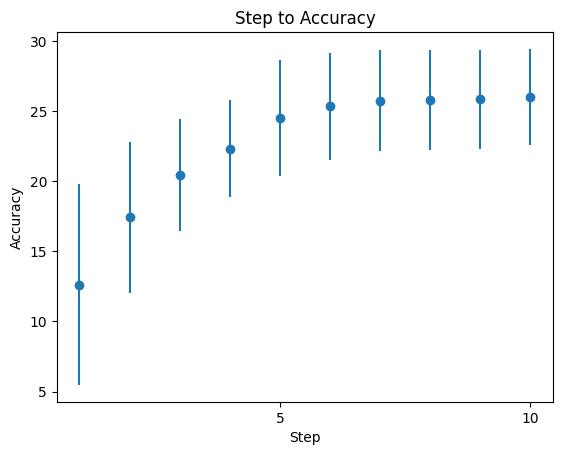

In [7]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [8]:
opro_results[str(len(opro_results))]

{'Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excluding the original text or additional information. Ensure that your translation maintains the same meaning and context as the original text, preserving its overall tone and style. Provide a fluent, natural-sounding translation that reads as if written by a native speaker. \n\n**Original text:**\n\n{TEXT}': 36.25961538461539,
 'Translate the following text into {LANGUAGE}. Please return only the translated content. Do not include the original text or any additional instructions. \n\n{TEXT}': 32.126696832579185,
 'Translate the following text to {LANGUAGE}. Provide the translated text only. Exclude the original text and any instructions or additional content. Ensure the translation is of high quality and accuracy, with flawless grammar, sentence structure, and word choice. Make the translation sound fluent and natural, as if a native speaker had written it.\n\n```\n{TEXT}\n```': 3

In [9]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Initial Prompt: 11.315493014744142


Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excludi…

Optimized Prompt (Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excluding the original text or additional information. Ensure that your translation maintains the same meaning and context as the original text, preserving its overall tone and style. Provide a fluent, natural-sounding translation that reads as if written by a native speaker. 

**Original text:**

{TEXT}): 20.49125059050172


In [10]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, original_data)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, original_data)}")

Please help me to translate the following text to {LANGUAGE}. Please return only translated content not includ…

Initial Prompt: 34.009361560807875


Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excludi…

Optimized Prompt (Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excluding the original text or additional information. Ensure that your translation maintains the same meaning and context as the original text, preserving its overall tone and style. Provide a fluent, natural-sounding translation that reads as if written by a native speaker. 

**Original text:**

{TEXT}): 40.093993577505756


### Example

In [11]:
res = opro.generate(
    best_instruction.format(LANGUAGE="Spanish", TEXT=original_data["english"][0]),
    model="gemma",  # gemma
)
original_data["spanish"][0], res, sentence_bleu(original_data["spanish"][0], res)

('¡Qué aburrimiento!',
 '¡Qué aburrido!\n\nThis translation maintains the same meaning and context as the original text, while being a fluent and natural-sounding translation.',
 0.6091989278793335)

In [12]:
res = opro.generate(
    CHOSEN_PROMPT.format(LANGUAGE="Spanish", TEXT=original_data["english"][0]),
    model="gemma",  # gemma
)
original_data["spanish"][0], res, opro.similarity(original_data["spanish"][0], res)

('¡Qué aburrimiento!',
 '¡Es aburrido!\n\nThe translated text is "How boring!".',
 0.7065099477767944)